In [15]:
import sys,os,time,pickle

#numerical stuff
import scipy as sp # is this necessary? 
import numpy as np # is this necessary?
import networkx as nx # is this necessary? 

#plotting stuff
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import random as ra # is this necessary?

#clustering
from sklearn.cluster import AgglomerativeClustering # is this necessary?
from sklearn.cluster import KMeans # is this necessary?
from sklearn.cluster import DBSCAN # is this necessary?

#metrics
from sklearn.metrics import adjusted_rand_score as ari
from sklearn.metrics import pairwise_distances

#graspy and lgc
from graspy.embed import *
from graspy.simulations import sbm
from graspy.cluster import GaussianCluster
import localgraphclustering as lgc

from joblib import Parallel, delayed

from tqdm import tqdm

This notebook investigates the performance of LGC and global spectral methods on a class of community detection tasks. In particular, assume $ A \sim SBM(\pi, n, B) $ where 

$$ B = \begin{bmatrix} p & q & ... & q \\ \vdots & \ddots & & \vdots\\ \vdots & & \ddots & \vdots \\ q & ... & q & p \end{bmatrix} $$

and $ \pi = \frac{1}{K} \begin{bmatrix} 1 & 1 & .. & 1 \end{bmatrix} ^{T} $. Apart from the effects of $ p $ and $ q $ on the two clustering techniques, there are two important regimes we are interested in: $ K = O(1) $ and $ K = o(n) $. In the first part of the notebook we fix $ K $. In the second part we allow $ K $ to grow as $ log(n) $ 

In [96]:
# K fixed, n grows, q is fixed 

K = 2 # Fix number of clusters to be 2
nh = 500 # step size for the ns we consider
ns = np.arange(500, 10000 + nh, step=nh) # sizes of graph to consider
mc_its = 10 # number of iterations

p = 0.5 # within-block probability of edge
q = 0.1 # between block probability of edge
B = np.array([
    [p, q],
    [q, p]
])

pi = (1/K) * np.ones(K) # class membership priors

def experiment(n, pi, B, n_cores=0, acorn=None):
    if acorn is not None:
        np.random.seed(acorn)
        
    n_clusters = len(pi)
        
    P = np.random.multinomial(n, pi) # multi-nomial trial; number of vertices in each cluster
    Y = np.concatenate([i*np.ones(P[i]) for i in range(len(pi))]) # cluster "labels"
    A = sbm(P, B) # random adjacency matrix
    G = nx.from_numpy_array(A) # graph from adjacency matrix for lgc technique
    nx.write_edgelist(G, "sbm.edgelist",data=False)
    g = lgc.GraphLocal('sbm.edgelist','edgelist',' ') 
    
    ASE = AdjacencySpectralEmbed() # initialize object (defaults?)
    X_hat = ASE.fit_transform(A) # ASE(A)
    
    GMM = GaussianCluster(min_components=n_clusters, max_components=n_clusters) # initialize object
    y = GMM.fit_predict(X_hat) # estimate communities
    ari_ase = ari(y, Y) # how'd we do?!
    
    LSE = AdjacencySpectralEmbed() # initialize LSE object (defaults?)
    X_hat = LSE.fit_transform(A) # LSE(A); matrix operations are in function 
    
    GMM = GaussianCluster(min_components=n_clusters, max_components=n_clusters) # initialize object
    y = GMM.fit_predict(X_hat) # estimate communities
    ari_lse = ari(y, Y) # how'd we do?!
    
    # now local stuff, will require for loop over all nodes in graph..
    ACLs = np.ones((n,n))
    
    # parallelize this!
    
    if n_cores > 0:
        lambda_function = lambda x: lgc.approximate_PageRank(g, [x], normalize=False)[1]
        remaining_seeds = n
        loops = 0
        while remaining_seeds > 0:
            temp_range = np.arange(loops*n_cores, min([n, (loops + 1)*n_cores]))
            results = Parallel(n_jobs=n_cores)(delayed(lambda_function)(i) for i in temp_range)
            results = np.array(results)
            
#             print(temp_range, ACLs[temp_range, :].shape, results.shape)
#             print(results)

            ACLs[temp_range, :] = results
            
            loops+=1
            remaining_seeds = max([0, remaining_seeds - n_cores])
            
    else:
        for i in range(n):
            seed = [i]
            acl = lgc.approximate_PageRank(g,seed,normalize=False)[1] 
            ACLs[i] = acl
        
    #- 
    GMM_local = GaussianCluster(min_components=n_clusters,max_components=n_clusters) 
    y = GMM_local.fit_predict(ACLs) # naively cluster assuming gaussianity
    ari_lgc = ari(y, Y) # how'd we do?!
    
    return ari_ase, ari_lse, ari_lgc

def simulation(ns, k_function, p, q_function, mc_its, n_cores=0, acorn=None, verbose=False):
    ARIs = np.zeros((len(ns), 3, mc_its))
    
    for i, n in enumerate(tqdm(ns)):
        # get number of clusters
        if isinstance(k_function, int):
            n_clusters=k_function
        else:
            n_clusters = int(k_function(n))

        # assume equal probabilities for each cluster.. may want to change in future
        pi = 1 / n_clusters * np.ones(n_clusters)

        # get components of B matrix
        if isinstance(q_function, float):
            q = q_function
        else:
            q = q_function(n)

        rows_of_B = [q*np.ones(n_clusters) for i in range(n_clusters)]
        for j in range(n_clusters):
            rows_of_B[j][j] = p

        B = np.array(rows_of_B)

        if verbose:
            for j in range(mc_its):
                ARIs[i, :, j] = experiment(n, pi, B, n_cores, acorn)
            
        else:
            for j in range(mc_its):
                ARIs[i, :, j] = experiment(n, pi, B, n_cores, acorn)
            
    mean_ARIs = np.mean(ARIs, axis=2)
    stderr_ARIs = np.sqrt(np.var(ARIs, axis=2, ddof=1) / mc_its)
    
    return mean_ARIs, stderr_ARIs

In [97]:
ns = [100, 200, 500, 750, 1000, 1250]
mean, stderr = simulation(ns, k_function=2, p=0.5, q_function=0.2, mc_its=5, n_cores=40, verbose=True)

































  0%|          | 0/6 [00:00<?, ?it/s]































 17%|█▋        | 1/6 [00:09<00:45,  9.01s/it]































 33%|███▎      | 2/6 [00:17<00:35,  8.83s/it]































 50%|█████     | 3/6 [01:03<00:59, 19.97s/it]































 67%|██████▋   | 4/6 [02:33<01:22, 41.06s/it]































 83%|████████▎ | 5/6 [04:41<01:07, 67.12s/it]































100%|██████████| 6/6 [07:10<00:00, 91.65s/it]

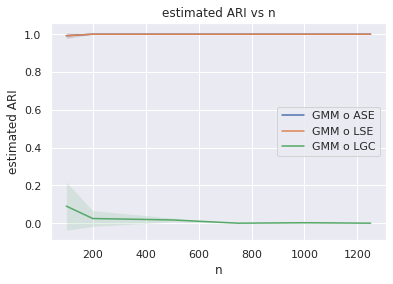

In [98]:
fig, ax = plt.subplots(1,1)

for i, algo in enumerate(['GMM o ASE', 'GMM o LSE', 'GMM o LGC']):
    ax.plot(ns, mean[:, i], label=algo)
    ax.fill_between(ns, 
            mean[:, i] + 1.96*stderr[:, i], 
            mean[:, i] - 1.96*stderr[:, i], 
            where=mean[:, i] + 1.96*stderr[:, i] >= mean[:, i] - 1.96*stderr[:, i], 
            alpha=0.15,
            interpolate=True)
    
ax.set_xlabel('n')
ax.set_ylabel('estimated ARI')
ax.set_title('estimated ARI vs n')
ax.legend()
plt.savefig('p05_fixed_q02_fixed_K2.png')
#     ax.scatter([100, 200, 500], mean[:, i], label = algo)
#     ax.scatter([100, 200, 500], mean1[:, i], label = algo)

In [101]:
ns = [100, 200, 500, 750, 1000, 1250]
mean, stderr = simulation(ns, k_function=5, p=0.5, q_function=0.2, mc_its=5, n_cores=40, verbose=True)


































  0%|          | 0/6 [00:00<?, ?it/s]
































 17%|█▋        | 1/6 [00:08<00:43,  8.78s/it]
































 33%|███▎      | 2/6 [00:17<00:34,  8.69s/it]
































 50%|█████     | 3/6 [01:01<00:57, 19.23s/it]
































 67%|██████▋   | 4/6 [02:37<01:24, 42.44s/it]
































 83%|████████▎ | 5/6 [05:24<01:19, 79.68s/it]
































100%|██████████| 6/6 [08:39<00:00, 114.33s/it]

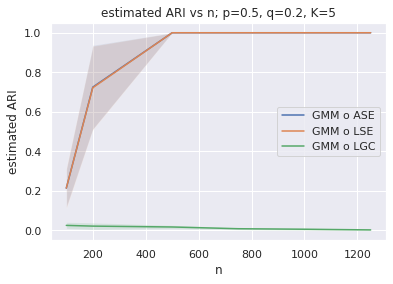

In [102]:
fig, ax = plt.subplots(1,1)

for i, algo in enumerate(['GMM o ASE', 'GMM o LSE', 'GMM o LGC']):
    ax.plot(ns, mean[:, i], label=algo)
    ax.fill_between(ns, 
            mean[:, i] + 1.96*stderr[:, i], 
            mean[:, i] - 1.96*stderr[:, i], 
            where=mean[:, i] + 1.96*stderr[:, i] >= mean[:, i] - 1.96*stderr[:, i], 
            alpha=0.15,
            interpolate=True)
    
ax.set_xlabel('n')
ax.set_ylabel('estimated ARI')
ax.set_title('estimated ARI vs n; p=0.5, q=0.2, K=5')
ax.legend()
plt.savefig('p05_fixed_q02_fixed_K5.png')

In [ ]:
ns = [100, 200, 500, 750, 1000, 1250]
mean, stderr = simulation(ns, k_function=np.log, p=0.5, q_function=0.2, mc_its=5, n_cores=40, verbose=True)


































  0%|          | 0/6 [00:00<?, ?it/s]
































 17%|█▋        | 1/6 [00:02<00:13,  2.78s/it]
































 33%|███▎      | 2/6 [00:10<00:16,  4.21s/it]
































 50%|█████     | 3/6 [00:54<00:48, 16.23s/it]
































 67%|██████▋   | 4/6 [02:35<01:23, 41.75s/it]
































 83%|████████▎ | 5/6 [05:37<01:23, 83.61s/it]

In [104]:
fig, ax = plt.subplots(1,1)

for i, algo in enumerate(['GMM o ASE', 'GMM o LSE', 'GMM o LGC']):
    ax.plot(ns, mean[:, i], label=algo)
    ax.fill_between(ns, 
            mean[:, i] + 1.96*stderr[:, i], 
            mean[:, i] - 1.96*stderr[:, i], 
            where=mean[:, i] + 1.96*stderr[:, i] >= mean[:, i] - 1.96*stderr[:, i], 
            alpha=0.15,
            interpolate=True)
    
ax.set_xlabel('n')
ax.set_ylabel('estimated ARI')
ax.set_title('estimated ARI vs n; p=0.5, q=0.2, K=log(n)')
ax.legend()
plt.savefig('p05_fixed_q02_change_Klog.png')

In [105]:
ns = [100, 200, 500, 750, 1000, 1250]
mean, stderr = simulation(ns, k_function=np.log, p=0.5, q_function=0.1, mc_its=5, n_cores=40, verbose=True)


































 67%|██████▋   | 4/6 [02:09<01:09, 34.66s/it]
































 83%|████████▎ | 5/6 [04:42<01:10, 70.08s/it]
































100%|██████████| 6/6 [09:03<00:00, 127.35s/it]

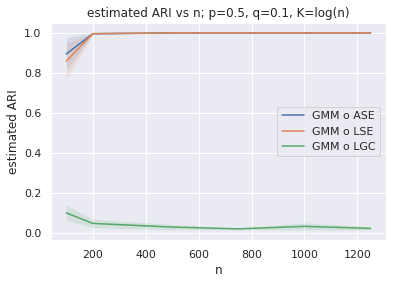

In [106]:
fig, ax = plt.subplots(1,1)

for i, algo in enumerate(['GMM o ASE', 'GMM o LSE', 'GMM o LGC']):
    ax.plot(ns, mean[:, i], label=algo)
    ax.fill_between(ns, 
            mean[:, i] + 1.96*stderr[:, i], 
            mean[:, i] - 1.96*stderr[:, i], 
            where=mean[:, i] + 1.96*stderr[:, i] >= mean[:, i] - 1.96*stderr[:, i], 
            alpha=0.15,
            interpolate=True)
    
ax.set_xlabel('n')
ax.set_ylabel('estimated ARI')
ax.set_title('estimated ARI vs n; p=0.5, q=0.1, K=log(n)')
ax.legend()
plt.savefig('p05_fixed_q01_change_Klog.png')

In [107]:
ns = [100, 200, 500, 750, 1000, 1250]
def reciprocal(n):
    return 1/n

def reciprocal3(n):
    return 3/n

mean, stderr = simulation(ns, k_function=np.log, p=0.5, q_function=reciprocal, mc_its=5, n_cores=40, verbose=True)


































  0%|          | 0/6 [00:00<?, ?it/s]
































 17%|█▋        | 1/6 [00:02<00:13,  2.61s/it]
































 33%|███▎      | 2/6 [00:08<00:14,  3.60s/it]

ValueError: shape mismatch: value array of shape (40,) could not be broadcast to indexing result of shape (40,500)

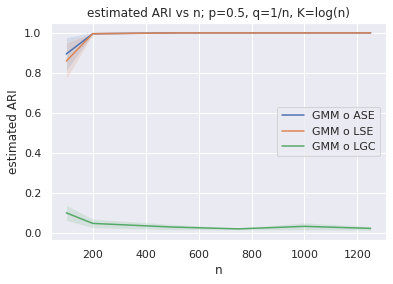

In [108]:
fig, ax = plt.subplots(1,1)

for i, algo in enumerate(['GMM o ASE', 'GMM o LSE', 'GMM o LGC']):
    ax.plot(ns, mean[:, i], label=algo)
    ax.fill_between(ns, 
            mean[:, i] + 1.96*stderr[:, i], 
            mean[:, i] - 1.96*stderr[:, i], 
            where=mean[:, i] + 1.96*stderr[:, i] >= mean[:, i] - 1.96*stderr[:, i], 
            alpha=0.15,
            interpolate=True)
    
ax.set_xlabel('n')
ax.set_ylabel('estimated ARI')
ax.set_title('estimated ARI vs n; p=0.5, q=1/n, K=log(n)')
ax.legend()
plt.savefig('p05_change_q1n_change_Klog.png')

In [110]:
ns = [100, 200, 500, 750, 1000, 1250]
def reciprocal(n):
    return 1/n

def reciprocal3(n):
    return 3/n

mean, stderr = simulation(ns, k_function=np.log, p=0.5, q_function=reciprocal3, mc_its=5, n_cores=40, verbose=True)




































  0%|          | 0/6 [00:00<?, ?it/s]


































 17%|█▋        | 1/6 [00:08<00:42,  8.44s/it]


































 33%|███▎      | 2/6 [00:15<00:31,  7.88s/it]


































 50%|█████     | 3/6 [00:41<00:40, 13.36s/it]

ValueError: shape mismatch: value array of shape (40,) could not be broadcast to indexing result of shape (40,750)

In [ ]:
fig, ax = plt.subplots(1,1)

for i, algo in enumerate(['GMM o ASE', 'GMM o LSE', 'GMM o LGC']):
    ax.plot(ns, mean[:, i], label=algo)
    ax.fill_between(ns, 
            mean[:, i] + 1.96*stderr[:, i], 
            mean[:, i] - 1.96*stderr[:, i], 
            where=mean[:, i] + 1.96*stderr[:, i] >= mean[:, i] - 1.96*stderr[:, i], 
            alpha=0.15,
            interpolate=True)
    
ax.set_xlabel('n')
ax.set_ylabel('estimated ARI')
ax.set_title('estimated ARI vs n; p=0.5, q=3/n, K=log(n)')
ax.legend()
plt.savefig('p05_change_q3n_change_Klog.png')

In [ ]:
mean, stderr = simulation(ns, k_function=2, p=0.5, q_function=reciprocal, mc_its=5, n_cores=40, verbose=True)

In [ ]:
fig, ax = plt.subplots(1,1)

for i, algo in enumerate(['GMM o ASE', 'GMM o LSE', 'GMM o LGC']):
    ax.plot(ns, mean[:, i], label=algo)
    ax.fill_between(ns, 
            mean[:, i] + 1.96*stderr[:, i], 
            mean[:, i] - 1.96*stderr[:, i], 
            where=mean[:, i] + 1.96*stderr[:, i] >= mean[:, i] - 1.96*stderr[:, i], 
            alpha=0.15,
            interpolate=True)
    
ax.set_xlabel('n')
ax.set_ylabel('estimated ARI')
ax.set_title('estimated ARI vs n; p=0.5, q=1/n, K=2')
ax.legend()
plt.savefig('p05_q1n_K2.png')

In [ ]:
mean, stderr = simulation(ns, k_function=2, p=0.5, q_function=reciprocal3, mc_its=5, n_cores=40, verbose=True)

In [ ]:
fig, ax = plt.subplots(1,1)

for i, algo in enumerate(['GMM o ASE', 'GMM o LSE', 'GMM o LGC']):
    ax.plot(ns, mean[:, i], label=algo)
    ax.fill_between(ns, 
            mean[:, i] + 1.96*stderr[:, i], 
            mean[:, i] - 1.96*stderr[:, i], 
            where=mean[:, i] + 1.96*stderr[:, i] >= mean[:, i] - 1.96*stderr[:, i], 
            alpha=0.15,
            interpolate=True)
    
ax.set_xlabel('n')
ax.set_ylabel('estimated ARI')
ax.set_title('estimated ARI vs n; p=0.5, q=3/n, K=2')
ax.legend()
plt.savefig('p05_q3n_K2.png')